# CMPUT 624 - Machine Learning and the Brain (2023)

*Notebook written by Alex Murphy (September 2023)*

This notebook is for the class workshop on **Thursday 28 September 2023**. Now that you have all handed in your project proposals, this workshop will give you a chance to see some examples of loading / visualising neural data. I will focus on EEG & fMRI because these are the modalities your teams have selected for your projects. We will also end with some examples of loading (large) language models (LLMs) via the HuggingFace library to extract text embeddings.

* Section 1: Working with EEG
* Section 2: Working with fMRI
* Section 3: Working with LLMs

# Section 2: Working with fMRI




Most file types you will come across in basic fMRI analysis will either be preprocessed NumPy arrays or the NiFTi format. You can recognise these files by their `.nii` extension. The information out of a scanner typically comes in a format called DICOM (`.dcm`) but the specifications are not always exactly the same. To aid working across research groups around the world, NIFTI was created a standard file type that everyone knows how to deal with. Often you will see gzip'd `.nii` files (i.e. `.nii.gz`) that need to be gunzip'd.

There are three parts to a NIFTI image: (1) the header information, (2) the imaging data and (3) the affine matrix. In the dataset for today, we're working with (1) and (2) and these have already been split up for us. Your `Session1` folder should contain `.hdr` (header) and `.img` files (imaging data files).

The `.img` files contain the brain scans. We will load some data and start visualising!

In [ ]:
!rm -r ./fMRI ./sMRI

In [ ]:
!wget https://www.fil.ion.ucl.ac.uk/spm/download/data/mmfaces/multimodal_fmri.zip
!unzip multimodal_fmri.zip

--2023-09-28 01:04:14--  https://www.fil.ion.ucl.ac.uk/spm/download/data/mmfaces/multimodal_fmri.zip
Resolving www.fil.ion.ucl.ac.uk (www.fil.ion.ucl.ac.uk)... 193.62.66.18
Connecting to www.fil.ion.ucl.ac.uk (www.fil.ion.ucl.ac.uk)|193.62.66.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134263085 (128M) [application/zip]
Saving to: ‘multimodal_fmri.zip.1’

multimodal_fmri.zip 100%[===================>] 128.04M  5.82MB/s    in 27s     

2023-09-28 01:04:42 (4.77 MB/s) - ‘multimodal_fmri.zip.1’ saved [134263085/134263085]

Archive:  multimodal_fmri.zip
   creating: fMRI/
 extracting: fMRI/trials_ses2.mat    
  inflating: fMRI/batch_fmri_stats.mat  
   creating: fMRI/Session1/
  inflating: fMRI/Session1/fMETHODS-0005-00327-000327-01.img  
  inflating: fMRI/Session1/fMETHODS-0005-00142-000142-01.img  
  inflating: fMRI/Session1/fMETHODS-0005-00032-000032-01.img  
  inflating: fMRI/Session1/fMETHODS-0005-00314-000314-01.hdr  
  inflating: fMRI/Session1/fMETHO

In [ ]:
!wget https://www.fil.ion.ucl.ac.uk/spm/download/data/mmfaces/multimodal_smri.zip
!unzip multimodal_smri

--2023-09-28 01:04:45--  https://www.fil.ion.ucl.ac.uk/spm/download/data/mmfaces/multimodal_smri.zip
Resolving www.fil.ion.ucl.ac.uk (www.fil.ion.ucl.ac.uk)... 193.62.66.18
Connecting to www.fil.ion.ucl.ac.uk (www.fil.ion.ucl.ac.uk)|193.62.66.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6852766 (6.5M) [application/zip]
Saving to: ‘multimodal_smri.zip.1’

multimodal_smri.zip 100%[===================>]   6.54M  3.24MB/s    in 2.0s    

2023-09-28 01:04:48 (3.24 MB/s) - ‘multimodal_smri.zip.1’ saved [6852766/6852766]

Archive:  multimodal_smri.zip
   creating: sMRI/
  inflating: sMRI/smri.img           
  inflating: sMRI/smri.hdr           
  inflating: sMRI/smri_fid.txt       


In [ ]:
!pip install -q nilearn nipype

In [ ]:
#!pip install --upgrade setuptools
#!pip install --upgrade pip

In [ ]:
!pip install --user cython
!git clone https://github.com/nipy/nipy
!pip install nipy/.

fatal: destination path 'nipy' already exists and is not an empty directory.
Processing ./nipy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nipy: filename=nipy-0.5.1.dev1-cp310-cp310-linux_x86_64.whl size=4886141 sha256=b7b8c5ab7b8c9a6d3fee9f648b9e64354bc4519388e990e8ee2e9ced23e0a501
  Stored in directory: /tmp/pip-ephem-wheel-cache-0wcscauc/wheels/8a/56/7e/73517b8258265c8d34a0fbcdff2d92b461478604184a494907
Successfully built nipy
  Attempting uninstall: nipy
    Found existing installation: nipy 0.5.1.dev1
    Uninstalling nipy-0.5.1.dev1:
      Successfully uninstalled nipy-0.5.1.dev1


## Data

In the previous notebook (Section1: EEG) there was a link to the data set. Use that link and now download the corresponding fMRI and structural data. Unzip the downloaded contents and put them in a new folder. Don't hide them away too much, as we will be writing out the file paths in the next cell.

In [ ]:
import nilearn as nil
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from nilearn import image
#from nilearn.plotting import image
from pathlib import Path

fMRI_folder = Path('./fMRI')
assert fMRI_folder.exists(), f"Foldder: {fMRI_folder} does not exist."

sMRI_folder = Path('./sMRI')
assert sMRI_folder.exists(), f"Foldder: {sMRI_folder} does not exist."

If you had any `AssertionError` notices pop up, it means the path was entered incorrectly or the folders do not exist.

We are now going to convert the `.img` files to `.nii` and make a single 4-dimensional file with a temporal sequence in the last axis, rather than deal with separate files per timestep. This will make all the later analyses much easier.

In [ ]:
sorted_img_files = sorted(list((fMRI_folder / 'Session1').glob('*.img')))
print(len(sorted_img_files))

for sorted_img_file in sorted_img_files:
    tmp = nib.load(sorted_img_file)
    new_fname = str(sorted_img_file).replace('.img', '.nii')
    save_loc = Path(new_fname.replace('Session1', 'Session1/nii'))
    save_loc.parent.mkdir(parents=True, exist_ok=True)
    nib.save(tmp, save_loc)

390


In [ ]:
dim_4d = [len(sorted_img_files)] + list(tmp.shape)
data_4d = np.zeros( (dim_4d)  )

for i, fname in enumerate(sorted(save_loc.parent.glob('*'))):
    #print(fname)
    tmp = image.load_img(fname)
    data_4d[i,:,:,:] = tmp.get_fdata()

# Put temporal dimension last
data_4d = np.transpose(data_4d, (1,2,3,0))
print(data_4d.shape)

nifti_4d = image.new_img_like(tmp, data=data_4d)

(64, 64, 32, 390)


In [ ]:
img_nii_4d = nib.Nifti1Image(data_4d, nifti_4d.affine)
nib.save(img_nii_4d, fMRI_folder / 'Session1' / 'nii' / 'nifti_4d.nii')

The above code is to convert the single image files into a 4-dimensional nifti file, as it's easier to work with a single data structure that has a temporal dimension.
Let's look at some properties of this data structure, such as its `type`, dimensionality of single time point (`.ndim`) and a sample of the values.

In [ ]:
sample_data = nifti_4d.get_fdata()[:,:,:,12]
print(sample_data.shape)
print(type(sample_data))
print(sample_data.ndim)
print(sample_data[0])

(64, 64, 32)
<class 'numpy.ndarray'>
3
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Question
Why do you think there are all zeros here?

Text(0.5, 1.0, 'Axial')

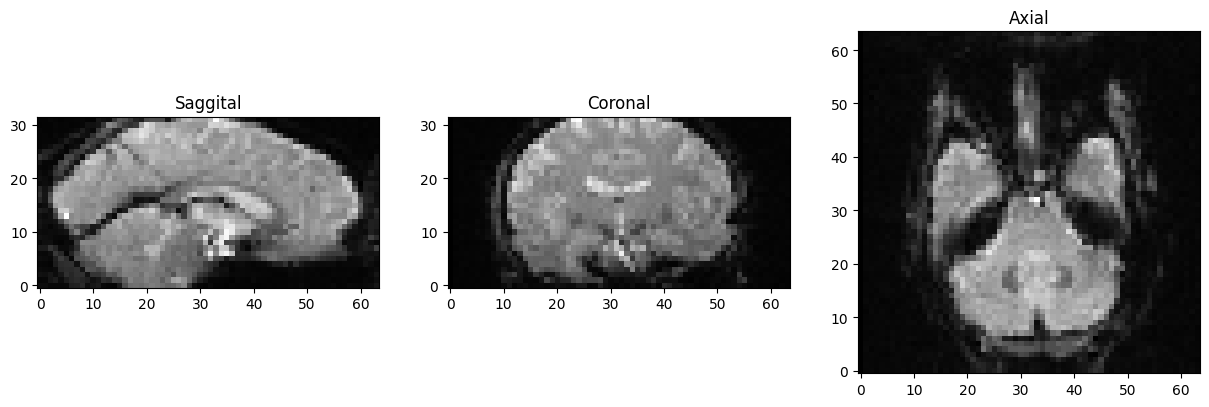

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3, figsize=(15,35))
axes = np.ravel(axes)

axes[0].imshow(sample_data[32,:,:].T, cmap='gray', origin='lower') # Saggital
axes[0].set_title("Saggital")
axes[1].imshow(sample_data[:,32,:].T, cmap='gray', origin='lower') # Coronal
axes[1].set_title("Coronal")
axes[2].imshow(sample_data[:,:,5].T, cmap='gray', origin='lower') # Axial
axes[2].set_title("Axial")

Plotting directly with `matplotlib.pyplot.imshow` requires just the NumPy data matrix, but `nilearn.plotting` functionality has special functions that can take a 3D volume and will give you the three different views (and options to specify any slice in the plotting function). The colour map is specifically designed to highlight what is brain and where activity levels (BOLD signal) is higher. Let's import the plotting functionality and call the function with our `sample` image's file path.

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:597: UserWarning: Casting data from int32 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")


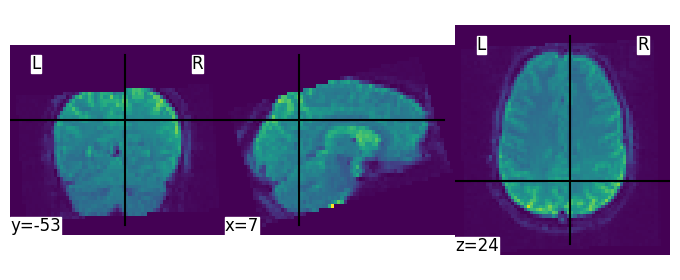

In [ ]:
from nilearn import plotting

plotting.plot_img(tmp)

How can we plot different slice values? Let's check the function signature.

In [ ]:
plotting.plot_img?

We need to pass in a list to `cut_coords` in order to select the index on each of the three axes. Let's pick `cut_coords=[0,0,0]` to see the centre value of the image, what is termed the origin point (close to the anterior commissure). Before we do any realignment, this might not be the case, but the main template brain that we try to warp participant brains into has the origin defined at the anterior commisure.

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:597: UserWarning: Casting data from int32 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")


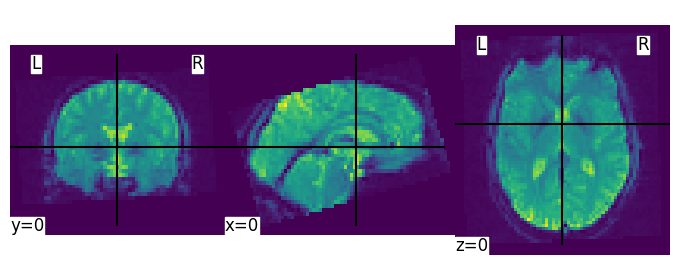

In [ ]:
plotting.plot_img(tmp, cut_coords=[0,0,0])

There is also a `plot_epi` function, specifically for functional fMRI data. The function we used above is general-purpose and can deal with many different types of MRI image, while the EPI version is specific and has a colour map that highlights BOLD activity better. Echo-Planar Imaging is the name of the method used to acquire fMRI data in a lot of cases, and is the method used for the dataset we are exploring. Particularly, the `plot_epi` function knows what values CSF looks like and marks them in red.

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:597: UserWarning: Casting data from int32 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")


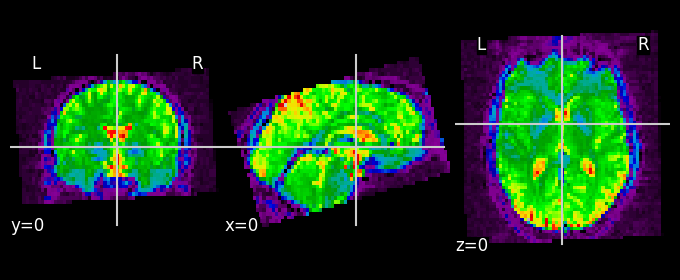

In [ ]:
plotting.plot_epi(tmp, cut_coords=[0,0,0])

## Structural Image (T1)

We won't be using the structural / anatomical MRI image until later on to plot some results, but in comparison to the functional images that have just been plotted, it's worth visualising this now. The functionality is interactive outside of coding notebooks, where you can pull the axes around to get differing views of the brain in 3D space.

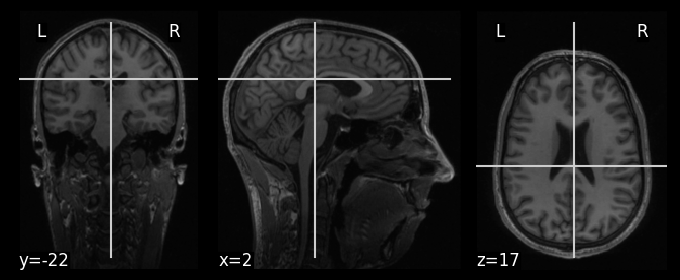

In [ ]:
T1 = image.load_img(sMRI_folder / 'smri.img')
plotting.plot_anat(T1)

## Motion Correction

As we saw in the slides, it's virtually impossible for a participant to remain completely still while in the scanner for an extended period of time and therefore the head position of a participant will shift ever so slightly in different directions. 3D fMRI volumes are acquired in the same physical space, so slight shifts might mean one voxel in the 3D volume was in a ventricle containing cerebra-spinal fluid (CSF) and then all of a sudden reflects brain activity from neurons via the BOLD response. We make an assumption in models of fMRI data that each voxel (3D pixel) plotted over time represents the same brain location and responses earlier on in the experiment, to certain stimuli, can be contrasted with responses later on in the same experiment. If the participant has moved, then this assumption is broken and it makes modelling and capturing true brain responses to our experimental manipulations very tricky.

Therefore, we need to extract the sequence of brain images in temporal order and align them to a reference image (it can be the first scan of a recording session, or the mean fMRI volume over the entire experiment, or median scan in the sequence etc.)

In [ ]:
from nipype.interfaces.nipy import SpaceTimeRealigner

nii_4D = fMRI_folder / 'Session1/nii/nifti_4d.nii'
realigner = SpaceTimeRealigner()
realigner.inputs.in_file = nii_4D
res = realigner.run()

/usr/local/lib/python3.10/dist-packages/nipy/io/files.py:141: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)


The output of the motion correction (realignment) step will put the corrected fMRI scans in the current folder, because we didn't specify a different save location.

In [ ]:
motion_corrected_path = Path('corr_nifti_4d.nii.gz')
data_mc = nib.load(motion_corrected_path)
print(data_mc.shape)

(64, 64, 32, 390)


We have now aligned all fMRI scans to the first image in the sequence, meaning, as best as possible, we have accounted for movement shifts in the scanner and now we have a 4-dimensional data matrix where the first three dimensions represent a single 3D volume and the fourth dimension is time. This means we can plot a voxel's BOLD value over time. Let's plot voxel (0,0,0). First, we'll define a helper function because we will display a few different voxel locations.

In [ ]:
def plot_voxel_seq(data, x,y,z,t, nilearn_viz=False):
    bold_sequence = data_mc.get_fdata()[x,y,z,:]
    scan_time_t = image.index_img(nii_4D, t)
    fig, axis = plt.subplots(figsize=(10,5))
    plt.plot(bold_sequence, c='r')
    axis.set_ylabel('BOLD Response')
    axis.set_xlabel('Time')
    axis.set_title(f'BOLD Sequence at voxel {x,y,z}')

    if nilearn_viz:
        x2, y2, z2 = image.coord_transform(x,y,z, scan_time_t.affine)
        plotting.plot_img(tmp, cut_coords=[x2,y2,z2])

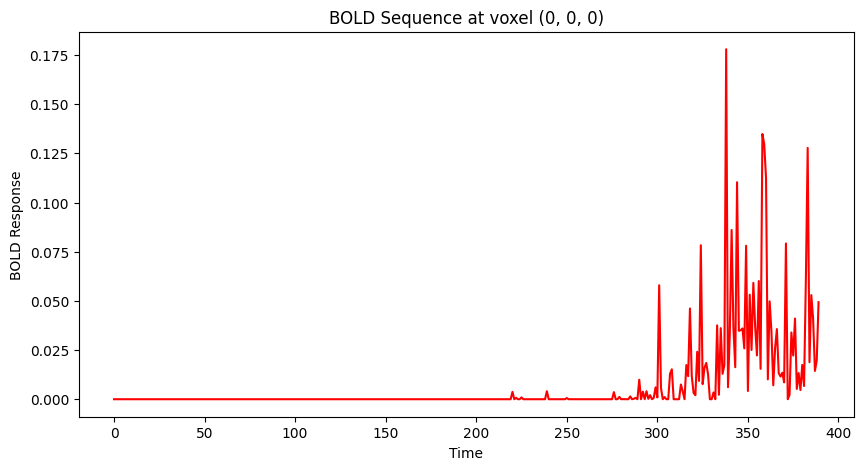

In [ ]:
plot_voxel_seq(data_mc, x=0, y=0, z=0, t=3)

## Question: What do you think is going on here?

Think of the brain as a 3D shape within a cube of voxels. In our NumPy matrices, the coordinate 0,0,0 would be a very corner voxel. This is not where the brain would be, so this is recording a signal outside of the brain. That's why it's mostly zeros. But what's going on at the end? What is that fluctuation? Remember, when we did motion correction, we aligned the brain scans to the first image, which means earlier on, while there is stability, this process worked quite well. However, movement accumulates over time and towards the end of the scanning session, some movement could not be exactly corrected and noise is introduced into this voxel. The scale of the noise is very small, compared to real signal.

Let's plot to see which voxel this is more visually (by setting `nilearn_viz=True` in our helper function)

/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:597: UserWarning: Casting data from int32 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")


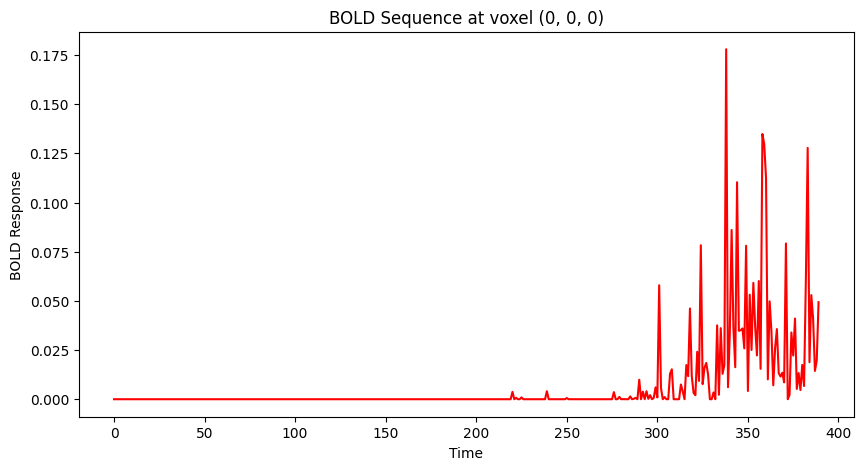

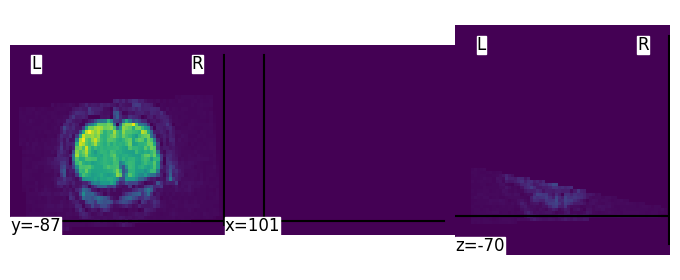

In [ ]:
plot_voxel_seq(data_mc, x=0, y=0, z=0, t=3, nilearn_viz=True)

The intersection of the black lines, signalling our voxel of interest, demonstrates we have selected a non-brain voxel here.
What about the centre of the 3D volume?

31 31 15


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:597: UserWarning: Casting data from int32 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")


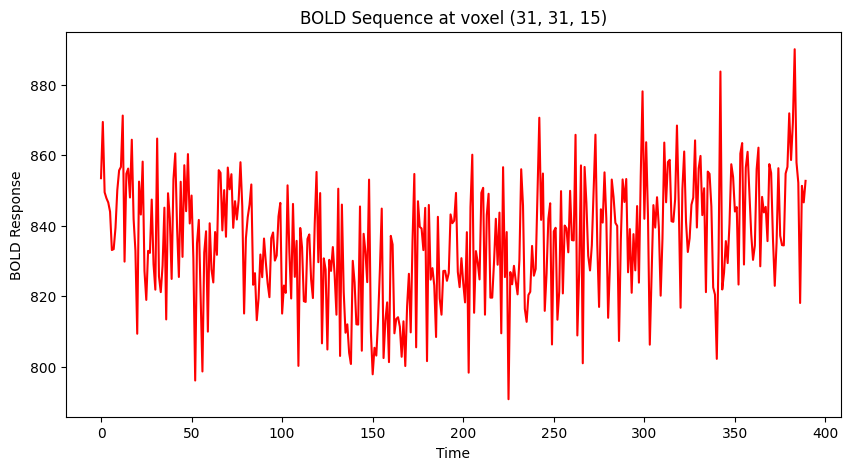

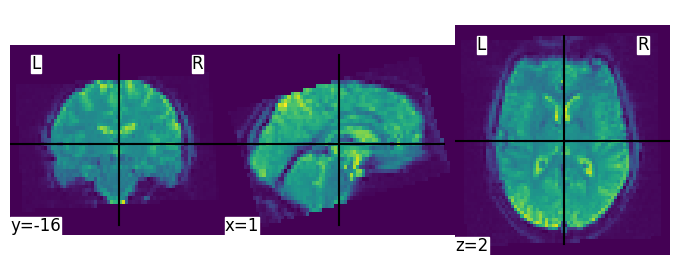

In [ ]:
x = (data_mc.shape[0] // 2) -1
y = (data_mc.shape[1] // 2) -1
z = (data_mc.shape[2] // 2) - 1

print(x,y,z)

plot_voxel_seq(data_mc, x=x, y=y, z=z, t=3, nilearn_viz=True)

The BOLD values here are much higher, because we have now intersected a brain voxel. However, look in the middle column and you will see we are right in the centre of the brain, in what looks like the 3rd ventricle. This is likely a voxel that doesn't have any neurons in, but signal can still be detected here. In the middle plot, at the back of the brain, there appears to be some higher activity there. Let's try and plot that.

31 31 15


/usr/local/lib/python3.10/dist-packages/nilearn/image/resampling.py:597: UserWarning: Casting data from int32 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")


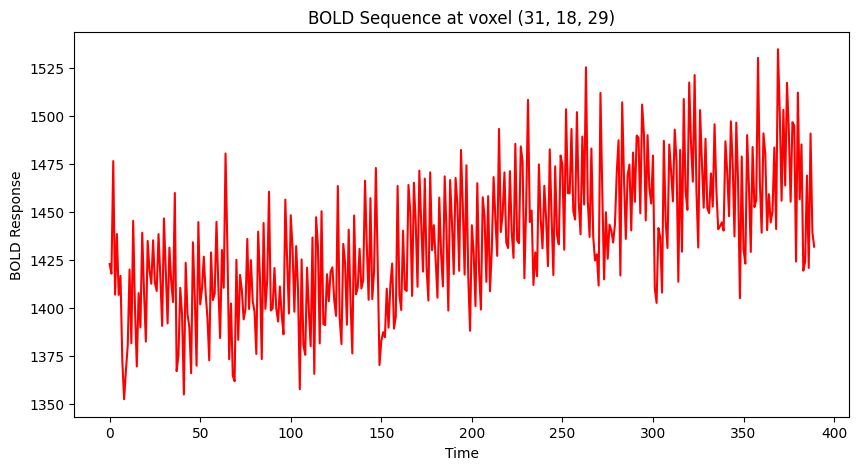

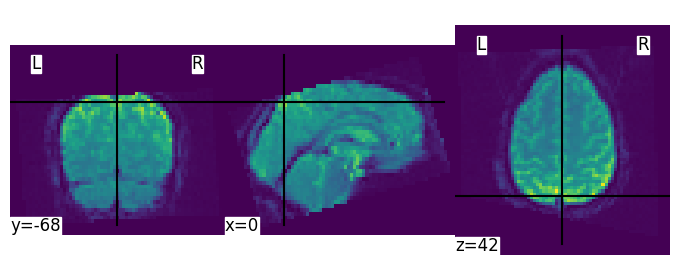

In [ ]:
x = (data_mc.shape[0] // 2) -1
y = (data_mc.shape[1] // 2) -1
z = (data_mc.shape[2] // 2) - 1

print(x,y,z)

plot_voxel_seq(data_mc, x=31, y=18, z=29, t=3, nilearn_viz=True)

These BOLD values are even higher, now that we have isolated a voxel on the cortex.

Normally, a step is introduced to calculate the brain mask, providing a mapping to locations in the 3D grid where the brain is present, and zeros where this is not. We are going to do a very crude thing instead to mimic this process. We will threshold each 3D scan by a value to determine brain-vs-non-brain. For your own projects, consider calculating a brain mask to do this properly.

(0.0, 1500.0)

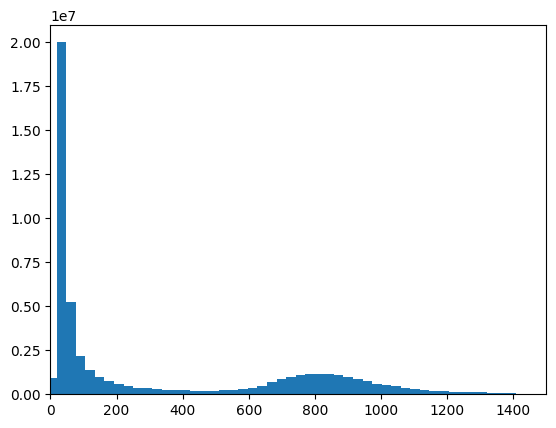

In [ ]:
plt.hist(data_mc.get_fdata().ravel(), bins=80);
plt.xlim(0,1500)

Let's eyeball this and set the cutoff around `100`.

In [ ]:
brain_mask = (data_mc.get_fdata().mean(axis=-1))>100

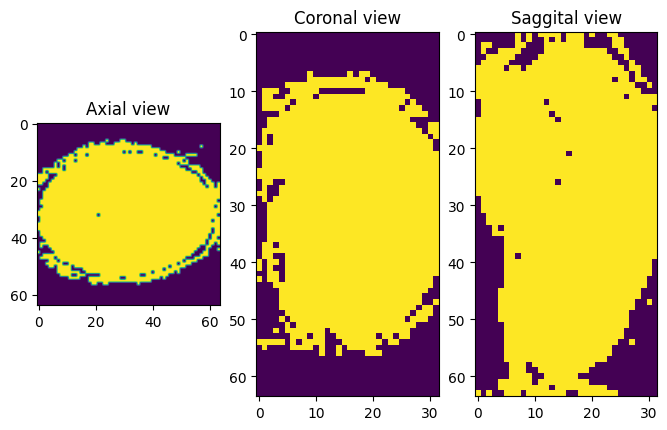

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(8,15))
axes = np.ravel(axes)
axes[0].imshow(brain_mask[:,:,16])
axes[0].set_title('Axial view');
axes[1].imshow(brain_mask[:,32,:])
axes[1].set_title('Coronal view');
axes[2].imshow(brain_mask[32,:,:])
axes[2].set_title('Saggital view');

These are rotated a little bit (the NiLearn functions for plotting could take into account a different image origin and corrected it for us). In the default case, the orientation is like this but you should be able to make the connection to the three slice dimnensions above.

For a quick demo, this should be sufficient.

#### About those time courses
But what is contained in this signal? Is there anything useful here relevant to face vs scrambled-face representation? How can we - at a very basic level - test this with machine learning?

## Coregistration

We will not apply coregistration in this notebook, but it's a step you might want to consider in your own analyses.

## Stimuli Loading

In the file we downloaded, there was a file called `trials_sess1.mat` which details the timing and stimuli type during the fMRI experiment. We will use `scipy` to load the MATLAB file, specifically with the function `scipy.io.loadmat`. We will then inspect the available sections and print out the values to get acquainted with the format.

In [ ]:
import scipy.io as sio

trials_ses1 = sio.loadmat(fMRI_folder / 'trials_ses1.mat')
print(trials_ses1.keys())

dict_keys(['__header__', '__version__', '__globals__', 'names', 'onsets', 'durations'])


We are interested in the final three: `names`, `onsets` and `durations`. The `durations` are actually all zeros, since visual presentation were presented and turned off, so we treat this like a stimulus pulse without any duration.

In [ ]:
trials_ses1['names']

array([[array(['faces'], dtype='<U5')],
       [array(['scrambled'], dtype='<U9')]], dtype=object)

The order of the stimuli here tell us that the indices for the classes are that:
* `1: faces`
* `2: scrambled`

MATLAB uses one-indexing, while Python uses zero-indexing, so for our purposes we will need to conver this at some point to the following:

* `0: faces`
* `1: scrambled`

If your data sets use MATLAB data, this is also something you should be aware of.

In [ ]:
trials_ses1['onsets']

array([[array([[  7.8615,  12.394 ,  44.119 ,  57.713 ,  62.2435,  63.755 ,
                 69.7985,  74.3365,  78.8685, 101.528 , 106.0615, 110.5935,
                112.105 , 113.6155, 115.1265, 116.6375, 121.1705, 128.7235,
                133.2535, 136.2745, 142.3235, 145.3495, 149.8795, 168.011 ,
                171.0325, 174.0525, 183.115 , 199.728 , 202.75  , 205.773 ,
                207.284 , 208.798 , 213.336 , 217.8695, 219.3805, 222.4045,
                228.451 , 231.474 , 245.0695, 258.665 , 261.687 , 264.707 ,
                269.238 , 270.7495, 278.305 , 281.331 , 282.845 , 285.867 ,
                288.8905, 294.933 , 314.573 , 320.6125, 325.145 , 326.6565,
                329.6765, 337.2285, 340.2505, 349.3175, 350.831 , 358.3855,
                359.8965, 376.5125, 382.5555, 385.5765]])                  ,
        array([[  1.8135,   9.373 ,  13.9055,  15.416 ,  18.4375,  19.949 ,
                 22.969 ,  29.009 ,  30.5205,  32.0315,  33.5425,  36.564 ,
           

We are given two arrays, of stimuluis onset times. We can see for the `faces` condition, as this was marked first in the `names` column, the first array here relates to that, while the second one relates to the stimulus onset times for the scrambled faces. Let's extract this information and make it convenient for Python.

NB: the data description tells us these onset values are not in seconds, but rather in `units of scans`. So, we can take the closest integer value to these and use this to extract a temporal index for later analysis.

In [ ]:
trials_ses1['onsets'][0][1][0]

array([  1.8135,   9.373 ,  13.9055,  15.416 ,  18.4375,  19.949 ,
        22.969 ,  29.009 ,  30.5205,  32.0315,  33.5425,  36.564 ,
        38.075 ,  42.607 ,  47.1405,  48.652 ,  68.285 ,  72.823 ,
        83.4   ,  84.911 ,  86.423 ,  93.9735,  98.505 , 100.0155,
       104.55  , 119.659 , 124.192 , 125.703 , 140.8105, 143.8365,
       151.3905, 152.9015, 155.923 , 157.435 , 161.9675, 163.479 ,
       175.5635, 177.0745, 181.6045, 190.665 , 192.176 , 193.687 ,
       201.239 , 204.2615, 211.8225, 220.892 , 223.916 , 225.428 ,
       229.9635, 232.9855, 236.006 , 237.5165, 239.028 , 240.538 ,
       243.558 , 246.5805, 248.091 , 251.112 , 252.6225, 257.154 ,
       267.727 , 273.77  , 276.7915, 287.379 , 296.4445, 297.9555,
       302.486 , 303.996 , 305.507 , 307.018 , 308.5295, 310.04  ,
       313.0615, 323.6335, 331.1875, 347.804 , 353.854 , 356.8745,
       364.4285, 367.4485, 370.469 , 373.4895, 375.001 , 378.024 ,
       381.044 , 387.0885])

In [ ]:
face_onsets = trials_ses1['onsets'][0][0][0]
scrambled_onsets = trials_ses1['onsets'][0][1][0]

As Python tries to read MATLAB's file structures, there can be many levels you need to index into before you find the specific array you are interested in. This took a bit of playing around with to figure out. Keep adding `[0]` until you see where you go from an array to a single value. This should tell you where the deepest index level is to extract a single array of onset times.

In [ ]:
print(face_onsets)
print(scrambled_onsets)

[  7.8615  12.394   44.119   57.713   62.2435  63.755   69.7985  74.3365
  78.8685 101.528  106.0615 110.5935 112.105  113.6155 115.1265 116.6375
 121.1705 128.7235 133.2535 136.2745 142.3235 145.3495 149.8795 168.011
 171.0325 174.0525 183.115  199.728  202.75   205.773  207.284  208.798
 213.336  217.8695 219.3805 222.4045 228.451  231.474  245.0695 258.665
 261.687  264.707  269.238  270.7495 278.305  281.331  282.845  285.867
 288.8905 294.933  314.573  320.6125 325.145  326.6565 329.6765 337.2285
 340.2505 349.3175 350.831  358.3855 359.8965 376.5125 382.5555 385.5765]
[  1.8135   9.373   13.9055  15.416   18.4375  19.949   22.969   29.009
  30.5205  32.0315  33.5425  36.564   38.075   42.607   47.1405  48.652
  68.285   72.823   83.4     84.911   86.423   93.9735  98.505  100.0155
 104.55   119.659  124.192  125.703  140.8105 143.8365 151.3905 152.9015
 155.923  157.435  161.9675 163.479  175.5635 177.0745 181.6045 190.665
 192.176  193.687  201.239  204.2615 211.8225 220.892  22

Note that there is a class imbalance here:

In [ ]:
print(f"Number of face classes: {len(face_onsets)}")
print(f"Number of scrambled-face classes: {len(scrambled_onsets)}")

Number of face classes: 64
Number of scrambled-face classes: 86


## Smoothing

We will not apply smoothing in this notebook, but it's an important step in your own analyses.

## Scaling

Remember in some non-brain voxels, the time series was very small in magnitude, in the ventricles it was slightly higher but up on the cortex it was even higher? These differences in absolute magnitude aren't helpful when comparing voxels across the brain for decoding. We need to normalise them to zero mean and unit variance, so when we later learn a logistic regression classifier, the magnitude of some voxels does not dominate over voxels with smaller magnitude (that might actually be more responsive to the decoding task).


In [ ]:
sess1_data = data_mc.get_fdata()
print(sess1_data.shape)

mean_along_temporal_axis = np.mean(sess1_data, axis=-1)
std_along_temporal_axis = np.std(sess1_data, axis=-1)
print(mean_along_temporal_axis.shape)
print(std_along_temporal_axis.shape)


(64, 64, 32, 390)
(64, 64, 32)
(64, 64, 32)


In [ ]:
mean = np.transpose(np.array([[mean_along_temporal_axis] * 390][0]), (1,2,3,0))
std = np.transpose(np.array([[std_along_temporal_axis] * 390][0]), (1,2,3,0))

In [ ]:
sess1_data_nm = (sess1_data - mean) / std

Let's pick a random voxel and see if it has zero mean and unit variance, like we want.

In [ ]:
print(sess1_data_nm[4,5,6,:].mean())
print(sess1_data_nm[4,5,6,:].std())

-8.073314097017805e-16
0.9999999999999998


We're going to do something a bit crude here and simply shift the onset times by 4 seconds then find the fMRI scan that encompasses that time interval. Then we will extract all voxels in that scan and assign them to the corresponding class (`faces` vs `scrambbled`). After we're done, we will have a set of samples and features with which we can train a classifier.

In [ ]:
face_onsets_shifted = face_onsets + 4
scrambled_onsets_shifted = scrambled_onsets + 4

Let's make sure this has worked.

In [ ]:
print(f'Face onsets')
print(face_onsets[0:5])
print(face_onsets_shifted[0:5])

print('\nScrambled onsets')
print(scrambled_onsets[0:5])
print(scrambled_onsets_shifted[0:5])

Face onsets
[ 7.8615 12.394  44.119  57.713  62.2435]
[11.8615 16.394  48.119  61.713  66.2435]

Scrambled onsets
[ 1.8135  9.373  13.9055 15.416  18.4375]
[ 5.8135 13.373  17.9055 19.416  22.4375]


The next thing we need is to be able to do is to associate the scans with these shifted times. To do this, we will first find the closest scan after the presentation of the stimulus in our shifted data. We can use the `ceiling` function to achieve this (`np.ceil`).

In [ ]:
face_onsets_idx = np.ceil(face_onsets_shifted)
scrambled_onsets_idx = np.ceil(scrambled_onsets_shifted)

In [ ]:
face_onsets_idx

array([ 12.,  17.,  49.,  62.,  67.,  68.,  74.,  79.,  83., 106., 111.,
       115., 117., 118., 120., 121., 126., 133., 138., 141., 147., 150.,
       154., 173., 176., 179., 188., 204., 207., 210., 212., 213., 218.,
       222., 224., 227., 233., 236., 250., 263., 266., 269., 274., 275.,
       283., 286., 287., 290., 293., 299., 319., 325., 330., 331., 334.,
       342., 345., 354., 355., 363., 364., 381., 387., 390.])

In [ ]:
scrambled_onsets_idx

array([  6.,  14.,  18.,  20.,  23.,  24.,  27.,  34.,  35.,  37.,  38.,
        41.,  43.,  47.,  52.,  53.,  73.,  77.,  88.,  89.,  91.,  98.,
       103., 105., 109., 124., 129., 130., 145., 148., 156., 157., 160.,
       162., 166., 168., 180., 182., 186., 195., 197., 198., 206., 209.,
       216., 225., 228., 230., 234., 237., 241., 242., 244., 245., 248.,
       251., 253., 256., 257., 262., 272., 278., 281., 292., 301., 302.,
       307., 308., 310., 312., 313., 315., 318., 328., 336., 352., 358.,
       361., 369., 372., 375., 378., 380., 383., 386., 392.])

Let's create some data structures to hold our results.

In [ ]:
from functools import reduce

flattened_shape = reduce(np.multiply, tmp.get_fdata().shape)

face_X      = np.zeros((len(face_onsets_shifted)-1,      flattened_shape ))
scrambled_X = np.zeros((len(scrambled_onsets_shifted)-1, flattened_shape ))

print(face_X.shape)


(63, 131072)


In [ ]:
for i, face_event_time in enumerate(face_onsets_idx):
    if face_event_time >= 390:
        continue
    tmp = data_mc.get_fdata()[:,:,:, int(face_event_time)]
    tmp[brain_mask == False] = 0
    tmp = tmp.ravel()
    #tmp = tmp[brain_mask]
    face_X[i,:] = tmp

In [ ]:
for i, scrambled_event_time in enumerate(scrambled_onsets_idx):
    if scrambled_event_time >= 390:
        continue
    tmp = data_mc.get_fdata()[:,:,:, int(scrambled_event_time)]
    tmp[brain_mask == False] = 0
    #tmp = tmp[brain_mask]
    tmp = tmp.ravel()
    scrambled_X[i,:] = tmp

Now let's combine the data from the two conditions, create a labels array and shuffle.

In [ ]:
data_X = np.vstack([face_X, scrambled_X])
labels = np.array([0] * face_X.shape[0] + [1] * scrambled_X.shape[0])

print(data_X.shape)
print(len(labels))


(148, 131072)
148


## Splitting & Shuffling the Data

We will now shuffle the data because when we stacked things together, all of one class was in one part and all of the other was in another part. When we split the data into training and testing folds, then this means the test data might never have been seen by the training data, so we need to shuffle things. This is just for this example. There are many reasons why this is a bad idea in a true experiment, because of autocorrelation in the fMRI signal and the independence assumption between samples does not hold (because previous visual stimulations from other classes affects data in other samples).

In [ ]:
from sklearn.model_selection import train_test_split

seed = 12
np.random.seed(seed)
idx = np.arange(len(labels))
np.random.shuffle(idx)
data_X = data_X[idx]
labels = labels[idx]

print(idx[:10])

X_train, X_test, y_train, y_test = train_test_split(data_X, labels,
                                                    test_size=0.10,
                                                    random_state=seed,
                                                    shuffle=False)

[144 129  46 102  21  16  98 143 146 135]


## Training a Classifier

Because there are many thousands of voxels, we will not do cross-validation here but it should be used in a limited-data regime in your own projects, if the computation time is feasible (it often isn't for large neural networks).

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_auc_score

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(dual=False, random_state=0))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Model score on test data: {roc_auc*100:.2f}%")

Model score on test data: 80.36%


Why didn't we use accuracy as a metric? What is the benefit to using ROC AUC?

Our limited data means there will likely be a lot of variance in the result, so let's run the model 25 times for fun and see what the distribution of the ROC AUC score is. This isn't statistically sound but there was some randomness in the result I couldn't fix by setting a seed (due to the C implementations of some of the packages being called to run the ML algorithms) and this just shows a sense of what the variance might be like with these data set sizes.

In [ ]:
# This takes a while to run, ignore for class

scores = []

for _ in range(50):
  idx = np.arange(len(labels))
  np.random.shuffle(idx)
  data_X = data_X[idx]
  labels = labels[idx]
  X_train, X_test, y_train, y_test = train_test_split(data_X, labels, test_size=0.10)
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  roc_auc = roc_auc_score(y_test, y_pred)
  scores.append(roc_auc)

Text(0.5, 0, 'ROC-AUC')

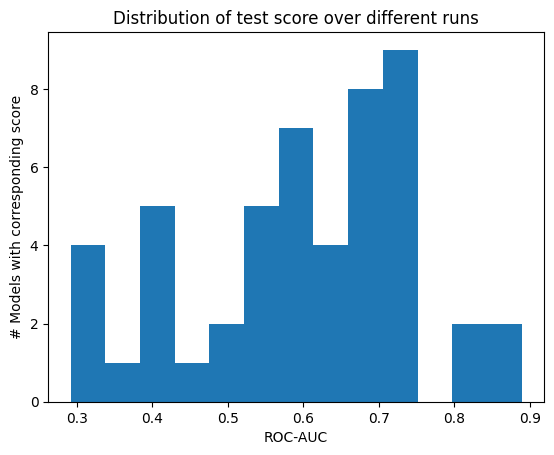

In [ ]:
plt.hist(scores, bins=13);
plt.title('Distribution of test score over different runs');
plt.ylabel('# Models with corresponding score')
plt.xlabel('ROC-AUC')

On some runs, we are unlucky and get a model that performs quite badly (ROC-AUC < 0.3 < 0.4) but more often than not we are between 0.6 - 0.7, which is good considering that it's noisy fMRI data with a basic tutorial-style set of steps (many important ones ignored for time!)

Many issues are ameliorated by larger training, validation and test set sizes. The importance of data quality and preprocessing for noisy data is much higher when in the low-data regime.

What if we changed the stimulus shift (+5 seconds instead of +4?) What about +6? If we added in Gaussian smoothing? Feel free to experiment!

## Visualusation

Let's reshape the voxel weights from the last model that was used to fit the data back into 3D space and plot the highest magnitude coefficients, namely, the ones most associated with solving the task of face vs scrambled-face processing.

In [ ]:
pipe.named_steps['clf'].coef_.shape

(1, 131072)

In [ ]:
lr_weights = pipe.named_steps['clf'].coef_
lr_weights_reshape = lr_weights.reshape((64,64,32))

In [ ]:
# Takes too long
#plt.hist(lr_weights)

In [ ]:
v = image.load_img(fMRI_folder / 'Session1' / 'nii/' 'fMETHODS-0005-00392-000392-01.nii')
v2 = image.new_img_like(v, data=lr_weights_reshape)

We'll first look at the Linear SVM coefficients reshaped back into the 3D functional volume and plotted on the participant's structural MRI image. We didn't coregister the functional images to the structural, so the alignment will be a bit off and you might see some voxels outside of the brain. We'll plot the same results on the mean functional image shortly. This is just to give you an impression of what results could look like when you have coregistered and maybe regenerated functional images to match up with the structural one.

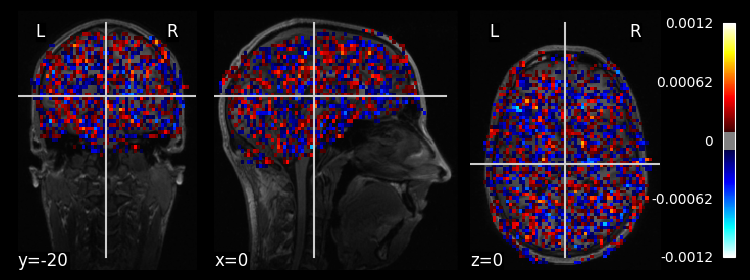

In [ ]:
plotting.plot_stat_map(v2, threshold=0.0001, bg_img=T1)

Each voxel has a coefficient from the Linear SVM classifier. But how do we know which ones are good and which ones are not? A proxy to this is to look at the magnitude of the coefficient for this task. We can change this by using the `threshold` parameter in `plot_stat_map`. Let's increase it a bit and see only the higher-magnitude voxels.

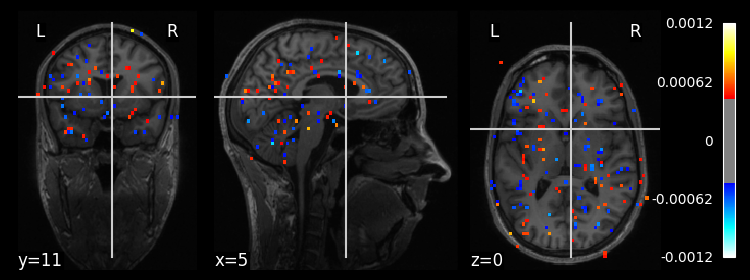

In [ ]:
plotting.plot_stat_map(v2, threshold=0.00045, bg_img=T1, cut_coords=[5,11,0])

We will now look at the mean functional image, that was actually used to generate the weights. Although we applied a motion correction step, we know this isn't perfect and we also didn't apply any smoothing operation on the data. This would greatly increase the quality of the results and that is left to you if you want to regenerate this with these steps added in. Performing this steps takes us out of Python and is not strictly relevant for the introductory goals of this session, however.

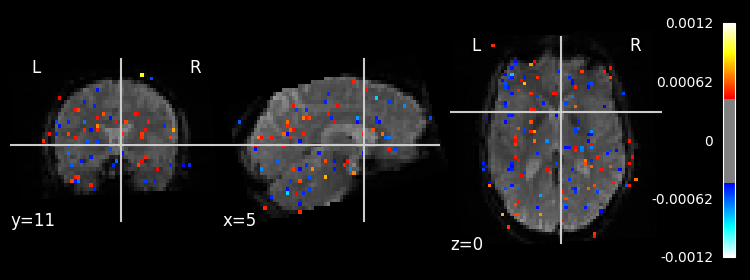

In [ ]:
mean_func = data_mc.get_fdata().mean(axis=-1)
mean_func = image.new_img_like(v, data=mean_func)
plotting.plot_stat_map(v2, threshold=0.00045, bg_img=mean_func, cut_coords=[5,11,0])

As voxels at the edge of the brain can slip in and out of different recorded voxel locations during the scanning process, this can introduce noise that could be correlated with the task in some cases. We also had an imperfect brain mask (we really should have used AFNI's `3dAutomask` program to calculate this for us). Primarily, this is just a basic guide to demonstrate visualisation techniques and how to plot results on brains.

Ideally, the datasets you have chosen will have already done many of these preprocessing steps and you will not need to worry too much. However, it's important to be aware of the steps that go into getting fMRI data from scanner to machine learning models.

## Resources

* [nilearn](https://nilearn.github.io/stable/index.html)
* [nibabel](https://nipy.org/nibabel)
* [nipype](https://nipype.readthedocs.io/en/latest)
* [nipy](https://nipy.org)
* [SPM website (MATLAB)](https://www.fil.ion.ucl.ac.uk/spm/software/spm12)

## What I left out

* Brain Masking (the proper way)
* Coregistration to an anatomical MRI scan
* Normalisation (different meaning than usual) to MNI template space
* Slice Time Correction
* GLM regression coefficients as features instead of raw BOLD values

# End of Part 2